In [2]:
import sys
sys.path.insert(0, '..')

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

from scipy.optimize import curve_fit

import reference_LFs as refLF
from paus_utils import *

from jpasLAEs.utils import bin_centers
from load_lya_LF import load_combined_LF

In [3]:
def power_fit(Lx, A, B):
    return 10 ** (A * (np.log10(Lx) - 43.5) + B)
    
def load_mcmc_powerlaw_fit():
    flat_samples = np.load('/home/alberto/cosmos/LAEs/npy/mcmc_powerlaw_fit_chain.npy')

    Phi_fit_i = []
    for ii, step in enumerate(flat_samples[::-1]):
        if ii == 10_000:
            break
        Phi_fit_i.append(power_fit(Lx, step[0], step[1]))
    Phi_fit_84 = np.percentile(Phi_fit_i, 84, axis=0)
    Phi_fit_16 = np.percentile(Phi_fit_i, 16, axis=0)
    Phi_fit_50 = np.percentile(Phi_fit_i, 50, axis=0)
    return Phi_fit_16, Phi_fit_50, Phi_fit_84

In [4]:
# Load the QSO mock to compare
from load_paus_mocks import load_qso_mock
from jpasLAEs.utils import flux_to_mag

source_cats_dir = '/home/alberto/almacen/Source_cats'
mock_path = f'{source_cats_dir}/QSO_PAUS_LAES_2'
mock = load_qso_mock(mock_path)

mock['r_mag'] = flux_to_mag(mock['flx_0'][-4], w_central[-4])

# Load the W3 catalog Xmatch with SDSS

sdss_xm = pd.read_csv('/home/alberto/almacen/PAUS_data/catalogs/Xmatch_SDSS_W3.csv')

In [5]:
from curve_fit.schechter_fit import schechter

def load_mcmc_schechter_fit(nb1, nb2):
    flat_samples = np.load(f'../curve_fit/chains/mcmc_schechter_fit_chain_nb{nb1}-{nb2}.npy')

    Phi_fit_i = []
    for ii, step in enumerate(flat_samples[::-1]):
        if ii == 10_000:
            break
        Phi_fit_i.append(schechter(Lx, 10**step[0], 10**step[1], step[2])
                        * Lx * np.log(10))
    Phi_fit_84 = np.percentile(Phi_fit_i, 84, axis=0)
    Phi_fit_16 = np.percentile(Phi_fit_i, 16, axis=0)
    Phi_fit_50 = np.percentile(Phi_fit_i, 50, axis=0)
    Phi_fit_05 = np.percentile(Phi_fit_i, 5, axis=0)
    Phi_fit_95 = np.percentile(Phi_fit_i, 95, axis=0)
    return Phi_fit_16, Phi_fit_50, Phi_fit_84, Phi_fit_05, Phi_fit_95

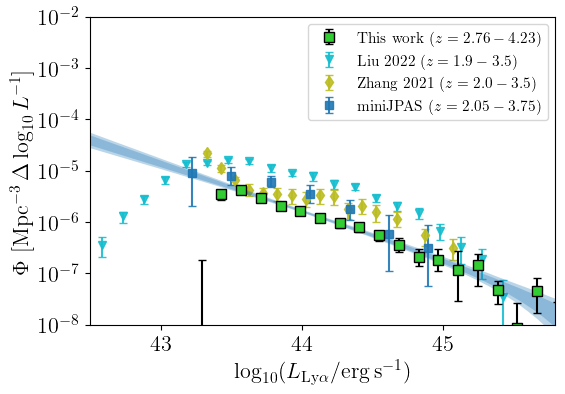

In [6]:
survey_list = ['W3']
nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16],
           [16, 18]]
# nb_list = [[0, 2]]


LyaLF = load_combined_LF(survey_list, nb_list, combined_LF=True)

# # LF of the mock
# nb1, nb2 = nb_list[0][0], nb_list[-1][-1]
# L_bins = np.linspace(40, 47, 100)
# L_bins_c = bin_centers(L_bins)
# L_bins_w = L_bins[1] - L_bins[0]
# mask_mock = ((NB_z(mock['zspec']) >= nb1)
#              & (NB_z(mock['zspec']) <= nb2)
#              & (mock['EW0_lya_spec'] > 30)
#              & (mock['r_mag'] < 24)
#              & (mock['r_mag'] > 17))
# mock_LF = np.histogram(mock['L_lya_spec'][mask_mock], L_bins)[0]\
#               / L_bins_w / Lya_effective_volume(nb1, nb2, 400)
# ax.plot(L_bins_c, mock_LF)

fig, ax = plt.subplots(figsize=(6, 4))

[yerr_up, yerr_down] = LyaLF['LF_total_err']
mask = (yerr_down == 0) & (LyaLF['LF_total'] > 0) # Where yerr_down boots is zero
yerr_down[mask] = LyaLF['LF_total'][mask]
mask = (yerr_up < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
yerr_up[mask] = LyaLF['poisson_err'][mask]
mask = (yerr_down < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
yerr_down[mask] = LyaLF['poisson_err'][mask]
ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_boots'],
            yerr=[yerr_down, yerr_up],
            fmt='s', ls='', mfc='limegreen', mec='k',
            ms=7, ecolor='k', capsize=3,
            label=f'This work $(z={z_NB(nb_list[0][0]):0.2f}-{z_NB(nb_list[-1][-1]):0.2f})$')

reference_LFs = [refLF.l22, refLF.z21, refLF.tt23_z2038]
for j, lf in enumerate(reference_LFs):
    ax.errorbar(lf['logL'], lf['Phi'],
                yerr=[lf['yerr_minus'], lf['yerr_plus']],
                linestyle='', fmt=lf['fmt'], c=lf['color'],
                alpha=0.9, label=lf['label'], capsize=3,
                zorder=-99)

# My fit
Lx = np.logspace(42, 46, 1000)
Phi_fit_16, Phi_fit_50, Phi_fit_84, Phi_fit_05, Phi_fit_95 = load_mcmc_schechter_fit(0, 18)
ax.fill_between(np.log10(Lx), Phi_fit_05, Phi_fit_95,
                alpha=0.3, color='C0', lw=0)
ax.fill_between(np.log10(Lx), Phi_fit_16, Phi_fit_84,
                alpha=0.3, color='C0', lw=0)

ax.set_yscale('log')
ax.set_ylim(1e-8, 1e-2)
ax.set_xlim(42.5, 45.8)

ax.legend(fontsize=11)

ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}/\mathrm{erg\,s}^{-1})$')
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\,\Delta\log_{10}L^{-1}$]')

ax.set_yticks(np.logspace(-8, -2, 7))

plt.show()

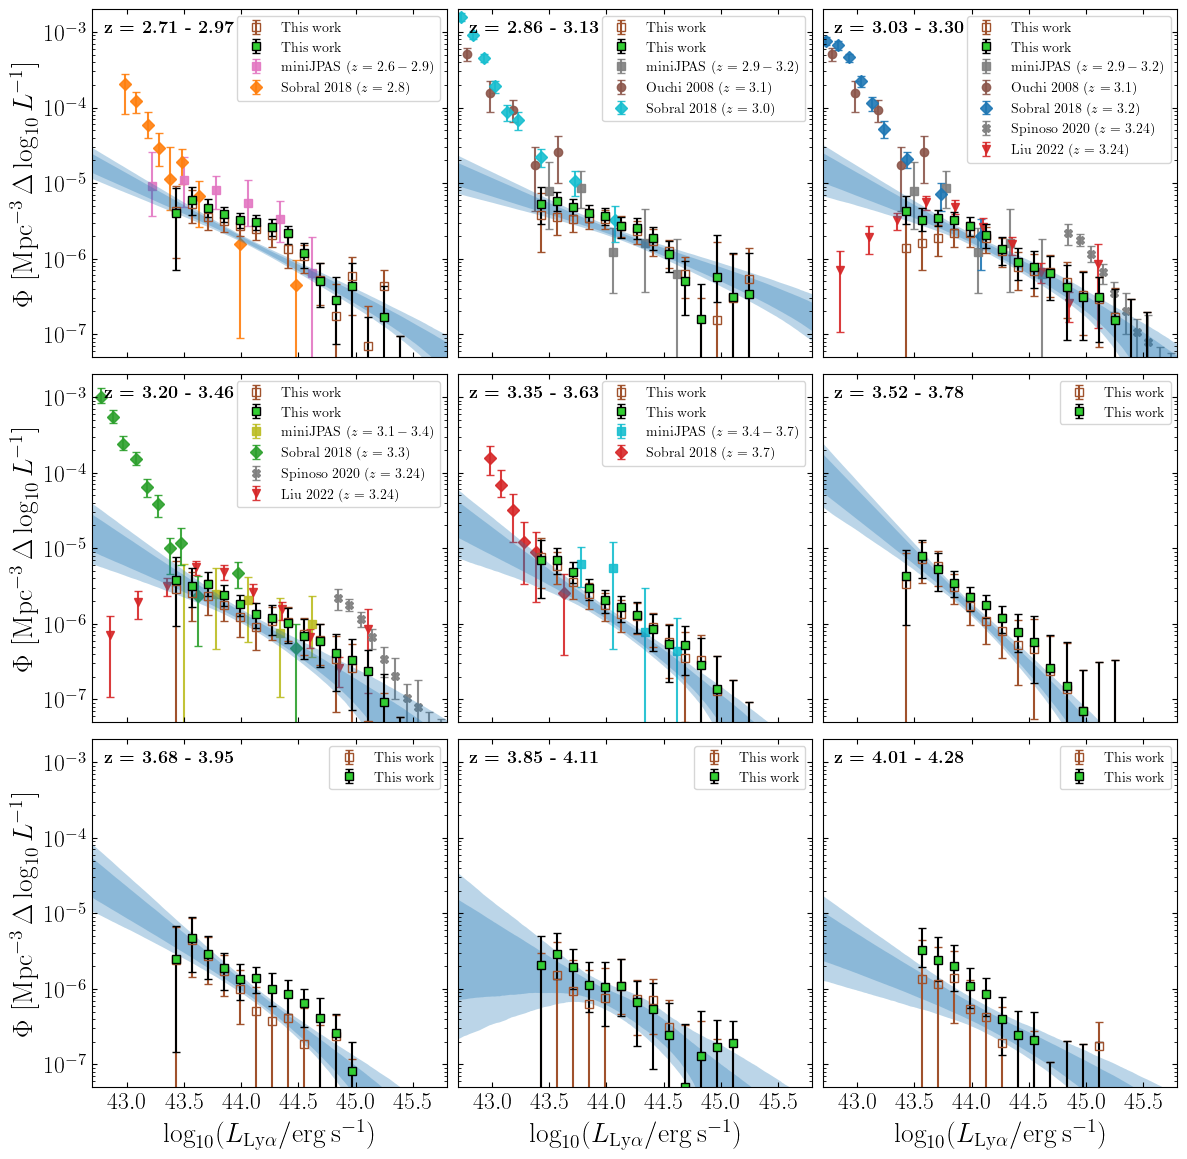

In [7]:
survey_list = ['W3']
nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16], [16, 18]]

fig, axs = plt.subplots(3, 3, figsize=(14, 14), sharey=True, sharex=True,
                        width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

reference_LFs = [[refLF.tt23_z2630, refLF.s18d],
                 [refLF.tt23_z2833, refLF.u08, refLF.s18b],
                 [refLF.tt23_z2833, refLF.u08, refLF.s18c, refLF.ds20_z324,
                  refLF.l22_z324],
                 [refLF.tt23_z3135, refLF.s18e, refLF.ds20_z324, refLF.l22_z324],
                 [refLF.tt23_z3338, refLF.s18f],
                 [],
                 [],
                 [],
                 []]

LFs_mult_list_combi = []
LFs_err_mult_list_combi = []

for iii, ax in enumerate(axs.flatten()):
    if len(nb_list[iii]) == 0:
        continue

    LyaLF = load_combined_LF(survey_list, [nb_list[iii]])


    [yerr_up, yerr_down] = LyaLF['LF_total_err']
    mask = (yerr_down == 0) & (LyaLF['LF_total'] > 0) # Where yerr_down boots is zero
    yerr_down[mask] = LyaLF['LF_total'][mask]
    mask = (yerr_up < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
    yerr_up[mask] = LyaLF['poisson_err'][mask]
    mask = (yerr_down < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
    yerr_down[mask] = LyaLF['poisson_err'][mask]
    ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_boots'],
                yerr=[yerr_down, yerr_up],
                fmt='s', ls='', mfc='none', mec='sienna',
                ms=6, ecolor='sienna', capsize=3,
                label='This work')
    ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_total'],
                yerr=[yerr_down, yerr_up],
                fmt='s', ls='', mfc='limegreen', mec='k',
                ms=6, ecolor='k', capsize=3,
                label='This work')

    LFs_mult_list_combi.append(LyaLF['LF_total'])
    LFs_err_mult_list_combi.append([yerr_up, yerr_down])

    if not iii % axs.shape[1]:
        ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\,\Delta\log_{10}L^{-1}$]', fontsize=20)
    if iii >= len(axs.flatten()) - axs.shape[1]:
        ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}/\mathrm{erg\,s}^{-1})$',
                      fontsize=20)


    nb_min = nb_list[iii][0]
    nb_max = nb_list[iii][1]
    z_min = (w_central[nb_min] - fwhm_Arr[nb_min] * 0.5) / w_lya - 1
    z_max = (w_central[nb_max] + fwhm_Arr[nb_max] * 0.5) / w_lya - 1
    ax.text(42.8, 1e-3, fr'\bf z = {z_min:0.2f} - {z_max:0.2f}',
            fontsize=13)

    for j, lf in enumerate(reference_LFs[iii]):
        ax.errorbar(lf['logL'], lf['Phi'],
                    yerr=[lf['yerr_minus'], lf['yerr_plus']],
                    linestyle='', fmt=lf['fmt'], c=lf['color'],
                    alpha=0.9, label=lf['label'], capsize=3,
                    zorder=-99)

    # Schechter fit
    Lx = np.logspace(42, 46, 1000)
    Phi_fit_16, Phi_fit_50, Phi_fit_84, Phi_fit_05, Phi_fit_95 =\
        load_mcmc_schechter_fit(*nb_list[iii])

    ax.fill_between(np.log10(Lx), Phi_fit_05, Phi_fit_95,
                    alpha=0.3, color='C0', lw=0)
    ax.fill_between(np.log10(Lx), Phi_fit_16, Phi_fit_84,
                    alpha=0.3, color='C0', lw=0)


    ax.set_ylim(5e-8, 2e-3)
    ax.set_xlim(42.7, 45.8)
    ax.set_yscale('log')

    ax.tick_params(labelsize=17, direction='in', which='both')
    ax.set_yticks(np.logspace(-7, -3, 5))
    xticks = np.arange(43, 46, 0.5)
    ax.set_xticks(xticks)
    # ax.set_xticklabels(f'{tick:0.1f}' for tick in xticks)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    # ax.set_xticks(np.arange(42.5, 46, 0.5))

    ax.legend(fontsize=10)

fig.subplots_adjust(wspace=0.03, hspace=0.05)

fig.savefig('../figures/multiLF.pdf', bbox_inches='tight', pad_inches=0.1,
            facecolor='w')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/alberto/almacen/PAUS_data/Lya_LFs/Lya_LF_nb2-4_W3/M_UV_bins.npy'

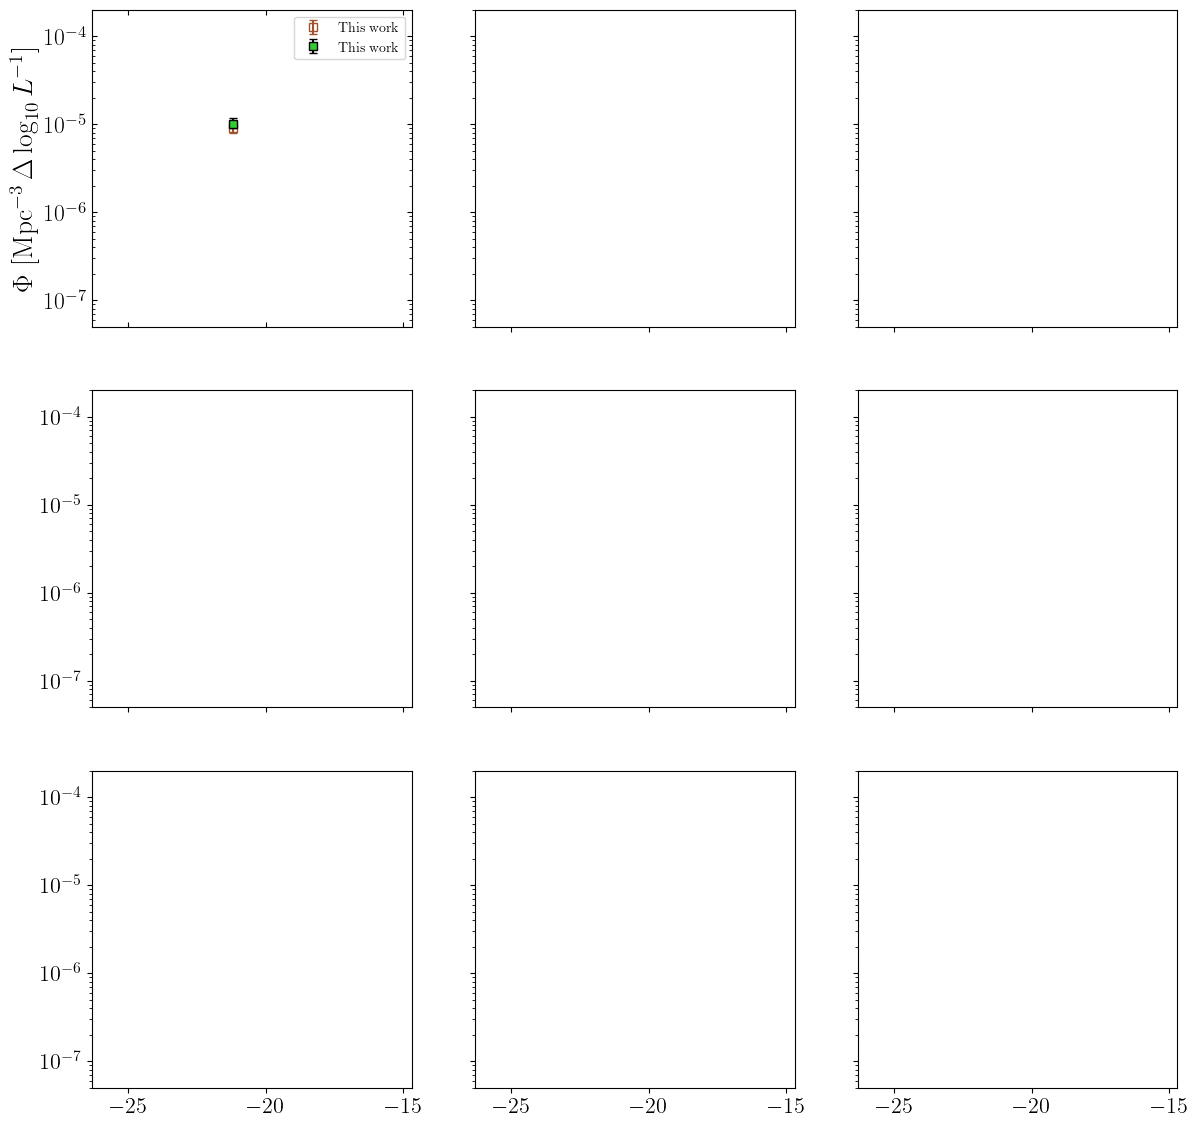

In [20]:
survey_list = ['W3']
nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16], [16, 18]]

fig, axs = plt.subplots(3, 3, figsize=(14, 14), sharey=True, sharex=True,
                        width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

for iii, ax in enumerate(axs.flatten()):
    if len(nb_list[iii]) == 0:
        continue

    LyaLF = load_combined_LF(survey_list, [nb_list[iii]], LF_kind='UV')

    [yerr_up, yerr_down] = LyaLF['LF_total_err']
    mask = (yerr_down == 0) & (LyaLF['LF_total'] > 0) # Where yerr_down boots is zero
    yerr_down[mask] = LyaLF['LF_total'][mask]
    mask = (yerr_up < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
    yerr_up[mask] = LyaLF['poisson_err'][mask]
    mask = (yerr_down < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
    yerr_down[mask] = LyaLF['poisson_err'][mask]
    ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_boots'],
                yerr=[yerr_down, yerr_up],
                fmt='s', ls='', mfc='none', mec='sienna',
                ms=6, ecolor='sienna', capsize=3,
                label='This work')
    ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_total'],
                yerr=[yerr_down, yerr_up],
                fmt='s', ls='', mfc='limegreen', mec='k',
                ms=6, ecolor='k', capsize=3,
                label='This work')

    if not iii % axs.shape[1]:
        ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\,\Delta\log_{10}L^{-1}$]', fontsize=20)
    if iii >= len(axs.flatten()) - axs.shape[1]:
        ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}/\mathrm{erg\,s}^{-1})$',
                      fontsize=20)


    nb_min = nb_list[iii][0]
    nb_max = nb_list[iii][1]
    z_min = (w_central[nb_min] - fwhm_Arr[nb_min] * 0.5) / w_lya - 1
    z_max = (w_central[nb_max] + fwhm_Arr[nb_max] * 0.5) / w_lya - 1
    # ax.text(42.8, 1e-3, fr'\bf z = {z_min:0.2f} - {z_max:0.2f}',
    #         fontsize=13)


    ax.set_ylim(1e-7, 1e-4)
    # ax.set_xlim(42.7, 45.8)
    ax.set_yscale('log')

    ax.tick_params(labelsize=17, direction='in', which='both')
    # ax.set_yticks(np.logspace(-7, -3, 5))
    # xticks = np.arange(43, 46, 0.5)
    # ax.set_xticks(xticks)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    ax.legend(fontsize=10)

fig.subplots_adjust(wspace=0.03, hspace=0.05)

fig.savefig('../figures/multiLF_UV.pdf', bbox_inches='tight', pad_inches=0.1,
            facecolor='w')
plt.show()

In [ ]:
survey_list = ['W3']
nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16], [16, 18]]

fig, axs = plt.subplots(3, 3, figsize=(14, 14), sharey=True, sharex=True,
                        width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

reference_LFs = [[refLF.tt23_z2630, refLF.s18d],
                 [refLF.tt23_z2833, refLF.u08, refLF.s18b],
                 [refLF.tt23_z2833, refLF.u08, refLF.s18c, refLF.ds20_z324,
                  refLF.l22_z324],
                 [refLF.tt23_z3135, refLF.s18e, refLF.ds20_z324, refLF.l22_z324],
                 [refLF.tt23_z3338, refLF.s18f],
                 [],
                 [],
                 [],
                 []]

for iii, ax in enumerate(axs.flatten()):
    if len(nb_list[iii]) == 0:
        continue

    for reg in survey_list:
        LyaLF = load_combined_LF([reg], [nb_list[iii]])

        [yerr_up, yerr_down] = LyaLF['LF_total_err']
        mask = (yerr_down == 0) & (LyaLF['LF_total'] > 0) # Where yerr_down boots is zero
        yerr_down[mask] = LyaLF['LF_total'][mask]
        mask = (yerr_up < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
        yerr_up[mask] = LyaLF['poisson_err'][mask]
        mask = (yerr_down < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
        yerr_down[mask] = LyaLF['poisson_err'][mask]
        ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_total'],
                    # yerr=[yerr_down, yerr_up],
                    fmt='s', ls='', mec='k',
                    ms=6, ecolor='k', capsize=3,
                    label=reg)

    LyaLF = load_combined_LF(survey_list, [nb_list[iii]])

    [yerr_up, yerr_down] = LyaLF['LF_total_err']
    mask = (yerr_down == 0) & (LyaLF['LF_total'] > 0) # Where yerr_down boots is zero
    yerr_down[mask] = LyaLF['LF_total'][mask]
    mask = (yerr_up < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
    yerr_up[mask] = LyaLF['poisson_err'][mask]
    mask = (yerr_down < LyaLF['poisson_err']) & (LyaLF['LF_total'] > 0)
    yerr_down[mask] = LyaLF['poisson_err'][mask]
    ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_total'],
                yerr=[yerr_down, yerr_up],
                fmt='s', ls='', mec='k',
                ms=6, ecolor='k', capsize=3,
                label='All')

    if not iii % axs.shape[1]:
        ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\,\Delta\log_{10}L^{-1}$]', fontsize=20)
    if iii >= len(axs.flatten()) - axs.shape[1]:
        ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}/\mathrm{erg\,s}^{-1})$',
                      fontsize=20)


    nb_min = nb_list[iii][0]
    nb_max = nb_list[iii][1]
    z_min = (w_central[nb_min] - fwhm_Arr[nb_min] * 0.5) / w_lya - 1
    z_max = (w_central[nb_max] + fwhm_Arr[nb_max] * 0.5) / w_lya - 1
    ax.text(42.8, 1e-5, fr'\bf z = {z_min:0.2f} - {z_max:0.2f}',
            fontsize=13)


    ax.set_ylim(5e-8, 2e-5)
    ax.set_xlim(42.7, 45.8)
    ax.set_yscale('log')

    ax.tick_params(labelsize=17, direction='in', which='both')
    ax.set_yticks(np.logspace(-7, -5, 3))
    xticks = np.arange(43, 46, 0.5)
    ax.set_xticks(xticks)
    # ax.set_xticklabels(f'{tick:0.1f}' for tick in xticks)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    # ax.set_xticks(np.arange(42.5, 46, 0.5))

    ax.legend(fontsize=10)

fig.subplots_adjust(wspace=0.03, hspace=0.05)

fig.savefig('../figures/multiLF.pdf', bbox_inches='tight', pad_inches=0.1,
            facecolor='w')
plt.show()

In [ ]:
pathname = '/home/alberto/cosmos/PAUS_LAEs/curve_fit/schechter_fit_parameters.csv'
sch_params = pd.read_csv(pathname)
display(sch_params.head())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

nb_min_Arr = np.array(sch_params['nb_min']).astype(int)
nb_max_Arr = np.array(sch_params['nb_max']).astype(int)
z_min_Arr = (w_central[nb_min_Arr] - fwhm_Arr[nb_min_Arr] * 0.5) / w_lya - 1
z_max_Arr = (w_central[nb_max_Arr] + fwhm_Arr[nb_max_Arr] * 0.5) / w_lya - 1
z_mid_Arr = (z_min_Arr + z_max_Arr) * 0.5

mask = (np.arange(len(sch_params)) < 9)
fit_param_list = ['Phistar', 'Lstar', 'alpha']

for i, ax in enumerate(axes.flatten()):
    this_param = fit_param_list[i]
    ax.errorbar(z_mid_Arr[mask], sch_params[this_param][mask],
                yerr=[sch_params[f'{this_param}_err_down'][mask],
                    sch_params[f'{this_param}_err_up'][mask]],
                xerr=(z_max_Arr - z_min_Arr)[mask] * 0.5,
                ls='', fmt='s', mfc='aqua', mec='k',
                ecolor='k', capsize=2
                )

    ax.set_xlabel('Redshift')
    ax.set_title(this_param)

plt.show()

In [ ]:
survey_list = ['W3']

fig, ax = plt.subplots(figsize=(6, 5))

LFs_mult_list = []
LFs_err_mult_list = []

for iii in range(19):
    LyaLF = load_combined_LF(survey_list, [[iii, iii]])
    LFs_mult_list.append(LyaLF['LF_total'])
    LFs_err_mult_list.append(LyaLF['LF_total_err'])

    ax.errorbar(LyaLF['LF_bins'] + iii * 0.01, LyaLF['LF_total'],
                yerr=LyaLF['LF_total_err'],
                fmt='s', ls='', mec='k',
                ms=6, ecolor='k', capsize=3,
                label=f'z = {z_NB(iii):0.2f}')


ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\,\Delta\log_{10}L^{-1}$]', fontsize=20)
ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}/\mathrm{erg\,s}^{-1})$',
                fontsize=20)

ax.set_ylim(5e-8, 2e-3)
ax.set_xlim(42.7, 45.7)
ax.set_yscale('log')

ax.tick_params(labelsize=17, direction='in', which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.legend(fontsize=10)

plt.show()

In [ ]:
Lmin, Lmax = 43.6, 47
# Lmin, Lmax = 44, 47
LF_bins = LyaLF['LF_bins']
bin_width = LF_bins[1] - LF_bins[0]
mask = (LF_bins < Lmax) & (LF_bins > Lmin)
mask_Lx = (np.log10(Lx) < Lmax) & (np.log10(Lx) > Lmin)

LF_err_list = np.array(
    [np.array(lf_err).sum(axis=0) * 0.5 for lf_err in LFs_err_mult_list])

LF_int_list = [(lf * bin_width)[mask].sum() for lf in LFs_mult_list]
LF_int_err_list = [((lf_err * bin_width)**2)[mask].sum() ** 0.5 for lf_err in LF_err_list]

z_list = []
this_nb_list = [[ii, ii] for ii in range(19)]
for [nb1, nb2] in this_nb_list:
    z_min = (w_central[nb1] - fwhm_Arr[nb1] * 0.5) / w_lya - 1
    z_max = (w_central[nb2] + fwhm_Arr[nb2] * 0.5) / w_lya - 1
    z_list.append([z_min, z_max])

z_central_list = [(zmax + zmin) * 0.5 for [zmin, zmax] in z_list]

# Load SDSS Xmatch
sdss_xm = pd.read_csv('/home/alberto/almacen/PAUS_data/catalogs/Xmatch_SDSS_W3.csv')

fig, ax = plt.subplots(figsize=(6, 4))

# ax.axhline(pl_int * 1e6, ls='--', c='r', lw=3,
#            label='LF power-law fit')
ax.errorbar(z_central_list, np.array(LF_int_list) * 1e6,
            yerr=np.array(LF_int_err_list) * 1e6,
            xerr=[(zmax - zmin) * 0.5 for [zmin, zmax] in z_list],
            fmt='o', ms=8, capsize=2,
            ecolor='k', mfc='limegreen', mec='k',
            label=r'This work', zorder=99)


# Fit to a power-law
def powerlaw_fit(x, a, b):
    return a * np.power(x, b)
popt, pcov = curve_fit(powerlaw_fit, z_central_list, LF_int_list,
                       sigma=LF_int_err_list)
ax.plot(z_central_list, powerlaw_fit(z_central_list, *popt) * 1e6,
        ls='--', lw=2.5, c='darkgreen', zorder=95,
        label='Power-law fit')
print(f'{popt=}')
print(f'{pcov=}')


# Load miniJPAS data
z_central_list = np.load('/home/alberto/cosmos/LAEs/npy/z_central_list.npy')
LF_int = np.load('/home/alberto/cosmos/LAEs/npy/LF_int_list.npy')
LF_int_yerr = np.load('/home/alberto/cosmos/LAEs/npy/LF_int_yerr_list.npy')
LF_int_xerr = np.load('/home/alberto/cosmos/LAEs/npy/LF_int_xerr_list.npy')
ax.errorbar(z_central_list, LF_int * 1e6,
            yerr=LF_int_yerr * 1e6,
            xerr=LF_int_xerr,
            fmt='s', ms=7, capsize=2,
            ecolor='gray', mfc='r', mec='gray',
            label=r'miniJPAS\&J-NEP', zorder=-1)


# Plot SDSS QSOs
z_bins = np.linspace(1.8, 4.3, 15)
z_bin_c = bin_centers(z_bins)
vol_Arr = [z_volume(z_bins[i], z_bins[i + 1], 14.76) for i in range(len(z_bins) - 1)]
h, _ = np.histogram(sdss_xm['z_best'][sdss_xm['L_lya'] > 43.6], z_bins)
ax.plot(z_bin_c, h / vol_Arr * 1e6,
        c='seagreen', label='SDSS QSO LAEs', zorder=-2)

# PD16
# area_obs = 14.76
# model = pd.read_csv('/home/alberto/cosmos/LAEs/MyMocks/csv/PD2016-QSO_LF.csv')
# counts_model_2D = model.to_numpy()[:-1, 1:-1].astype(float) * 1e-4 * area_obs
# z_xx = np.arange(0, 6.5, 1)
# vol_Arr = [z_volume(z_xx[i], z_xx[i + 1], 14.76) for i in range(len(z_xx) - 1)]
# z_model = counts_model_2D.sum(axis=0) / vol_Arr
# ax.plot(bin_centers(z_xx), z_model * 1e6,
#         marker='d', mfc='orange', mec='k', ms=12,
#         ls='', zorder=96)


handles, labels = ax.get_legend_handles_labels()
order = np.array([2, 0, 3, 1])
ax.legend(np.array(handles, dtype=object)[order],
            np.array(labels, dtype=object)[order],
            fontsize=12, ncol=1, loc=0)

ax.tick_params(labelsize=18, direction='in', which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set(ylim=(0, 7), xlim=(1.9, 4.3))
ax.set_ylabel('Integrated $\Phi$ [10$^{-6}$ Mpc$^{-3}$]', fontsize=18)
ax.set_xlabel('Redshift', fontsize=18)

fig.savefig('../figures/Integrated_LF.pdf', pad_inches=0.1, bbox_inches='tight',
            facecolor='w')
plt.show()

In [ ]:
Lmin, Lmax = 43.6, 47
LF_bins = LyaLF['LF_bins']
bin_width = LF_bins[1] - LF_bins[0]
mask = (LF_bins < Lmax) & (LF_bins > Lmin)
mask_Lx = (np.log10(Lx) < Lmax) & (np.log10(Lx) > Lmin)

LF_err_list = np.array(
    [np.array(lf_err).sum(axis=0) * 0.5 for lf_err in LFs_err_mult_list])

LF_int_list = [(lf * bin_width * 10**LF_bins)[mask].sum() for lf in LFs_mult_list]
LF_int_err_list = [((lf_err * bin_width * 10**LF_bins)**2)[mask].sum() ** 0.5 for lf_err in LF_err_list]

z_list = []
this_nb_list = [[ii, ii] for ii in range(19)]
for [nb1, nb2] in this_nb_list:
    z_min = (w_central[nb1] - fwhm_Arr[nb1] * 0.5) / w_lya - 1
    z_max = (w_central[nb2] + fwhm_Arr[nb2] * 0.5) / w_lya - 1
    z_list.append([z_min, z_max])

z_central_list = [(zmax + zmin) * 0.5 for [zmin, zmax] in z_list]


fig, ax = plt.subplots(figsize=(6, 5))

ax.errorbar(z_central_list, LF_int_list,
            yerr=LF_int_err_list,
            xerr=[(zmax - zmin) * 0.5 for [zmin, zmax] in z_list],
            fmt='o', ms=8, capsize=2,
            ecolor='k', mfc='limegreen', mec='k',
            label=r'This work (AGN)', zorder=99)


# Fit to a power-law
def linear_fit(x, a, b):
    return np.power(10., b + a * np.array(x))
popt, pcov = curve_fit(linear_fit, z_central_list, LF_int_list,
                       sigma=LF_int_err_list, p0=[1, 40])
z_xx = np.linspace(2, 4.6, 10)
ax.plot(z_xx, linear_fit(z_xx, *popt),
        ls='--', lw=2.5, c='darkgreen', zorder=95,
        label='Power-law fit')
print(f'{popt=}')
print(f'{pcov=}')


# Load miniJPAS data
z_central_list = np.load('/home/alberto/cosmos/LAEs/npy/z_central_list.npy')
LF_L_int = np.load('/home/alberto/cosmos/LAEs/npy/LF_L_int_list.npy')
LF_L_int_yerr = np.load('/home/alberto/cosmos/LAEs/npy/LF_L_int_yerr_list.npy')
LF_int_xerr = np.load('/home/alberto/cosmos/LAEs/npy/LF_int_xerr_list.npy')
ax.errorbar(z_central_list, LF_L_int,
            yerr=LF_L_int_yerr,
            xerr=LF_int_xerr,
            fmt='s', ms=7, capsize=2,
            ecolor='r', mfc='r', mec='dimgray',
            label=r'Torralba-Torregrosa+23 (AGN)', zorder=-1)


# Integrate LFs of the literature
# Liu 2022
lit_ref_list = [refLF.l22_z225, refLF.l22_z237,
                refLF.l22_z254, refLF.l22_z324]
lit_z_Arr = []
lit_int_list = []
lit_int_err_list = []
L_bin_w_list = []
for lf in lit_ref_list:
    lit_z_Arr.append(lf['z'])

    this_L_bin_width = lf['logL'][1] - lf['logL'][0]
    L_bin_w_list.append(this_L_bin_width)
    mask = lf['logL'] > 43.5
    lit_int_list.append((lf['Phi'] * this_L_bin_width * 10**lf['logL'])[mask].sum())
    lit_int_err_list.append((((lf['yerr_plus']) * this_L_bin_width * 10**lf['logL'])**2)[mask].sum() ** 0.5)

ax.errorbar(lit_z_Arr, lit_int_list,
            yerr=lit_int_err_list,
            fmt='X', ms=7, capsize=2,
            ecolor='orange', mfc='orange', mec='dimgray',
            label='Liu+22 (AGN)')

# Sobral+ 2018
pathname = '/home/alberto/almacen/PAUS_data/sobral2018_rho_Lya.csv'
s18_rho_lya = pd.read_csv(pathname)

ax.errorbar(s18_rho_lya['z'], 10**s18_rho_lya['rho_Lya'],
            yerr=[10**s18_rho_lya['rho_Lya_err_up'] - 10**s18_rho_lya['rho_Lya'],
                  10**s18_rho_lya['rho_Lya'] - 10**s18_rho_lya['rho_Lya_err_down']],
            fmt='d', ms=7, capsize=2,
            ecolor='skyblue', mfc='skyblue', mec='dimgray',
            label='Sobral+18 (SFG)')

# Lin+ 2022
ax.errorbar(2.4, 6.6e40, yerr=[[3.3e40], [3.1e40]],
            fmt='*', ms=7, capsize=2, ecolor='orchid',
            mfc='orchid', mec='dimgray',
            label='Lin+22 (IGM)')


ax.legend(fontsize=11, ncol=2,
          bbox_to_anchor=(1, 1.25))

ax.tick_params(labelsize=18, direction='in', which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlim(1.9, 4.6)
ax.set_ylim(1e37, 1e41)
ax.set_yscale('log')

ax.set_ylabel(r'$\rho_{\mathrm{Ly}\alpha}$ [erg\,s$^{-1}$\,Mpc$^{-3}$]', fontsize=18)
ax.set_xlabel('Redshift', fontsize=18)

fig.savefig('../figures/Integrated_Luminosity.pdf', pad_inches=0.1, bbox_inches='tight',
            facecolor='w')
plt.show()

In [ ]:
# from plot.puricomp1D import plot_puricomp1d

# nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
#            [8, 10], [10, 12], [12, 14], [14, 16], [16, 18]]
# # nb_list = [[0, 2]]
# r_min, r_max = 17, 24

# fig, axs = plt.subplots(2, 1, figsize=(6, 6),
#                         sharex=True)

# puricomp1d_L_bins = np.linspace(42.5, 45.5, 15)
# puricomp1d_L_bins_c = bin_centers(puricomp1d_L_bins)

# for jj, [nb_min, nb_max] in enumerate(nb_list):
#     print(f'nb{nb_min}-{nb_max}')
#     puri1d, comp1d = plot_puricomp1d('W3', nb_min, nb_max,
#                                      r_min, r_max,
#                                      L_bins=puricomp1d_L_bins)

#     color = f'C{jj}'
#     axs[0].plot(puricomp1d_L_bins_c, puri1d,
#                 label=f'NB: {nb_min}-{nb_max}',
#                 c=color)
#     axs[1].plot(puricomp1d_L_bins_c, comp1d,
#                 c=color)

# axs[0].set_ylabel('Purity')
# axs[1].set_ylabel('Completeness')

# for ax in axs:
#     ax.set_ylim(0, 1)
#     ax.set_xlabel('log L_Lya')

# axs[0].legend(fontsize=10)

# plt.show()